In [1]:
# 环境与路径
from pathlib import Path
import json, pickle
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from panopticapi import utils

repo = Path("~/gyk/F-LMM").expanduser()  # 根据实际情况调整
coco_root = repo / "data" / "coco"
png_ann = coco_root / "annotations" / "png_coco_train2017.json"
panoptic_json = coco_root / "annotations" / "panoptic_train2017.json"
panoptic_dir = coco_root / "annotations" / "panoptic_train2017"
images_dir = coco_root / "train2017"


In [9]:
# PNG 样本解析
with open(png_ann) as f:
    png_samples = json.load(f)



In [14]:
sample = png_samples[34]
sample

{'image_id': '428390',
 'annotator_id': 17,
 'caption': 'In this image I can see a train which is in purple and yellow color, at right I can see few light poles and a green color bench.',
 'segments': [{'utterance': 'in this',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'image', 'segment_ids': [], 'plural': False, 'noun': True},
  {'utterance': 'i can see a',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'train',
   'segment_ids': ['4081477'],
   'plural': False,
   'noun': True},
  {'utterance': 'which is in',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'purple', 'segment_ids': [], 'plural': False, 'noun': True},
  {'utterance': 'and', 'segment_ids': [], 'plural': False, 'noun': False},
  {'utterance': 'yellow color',
   'segment_ids': [],
   'plural': False,
   'noun': True},
  {'utterance': ', at right i can see',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance

In [11]:
from panopticapi.utils import rgb2id

# 读取一次元数据，建立快捷索引
with open(panoptic_json) as f:
    panoptic_meta = json.load(f)

In [ ]:
image_lookup = {int(img["id"]): img for img in panoptic_meta["images"]}
ann_lookup = {int(ann["image_id"]): ann for ann in panoptic_meta["annotations"]}

# 取一条样本
sample = png_samples[34]
image_id = int(sample["image_id"])

# 根据 image_id 拿到文件名
image_info = image_lookup[image_id]
ann_info = ann_lookup[image_id]
print(image_info)
print(ann_info)
sample_img = Image.open(images_dir / image_info["file_name"])
segm_map = rgb2id(np.array(Image.open(panoptic_dir / ann_info["file_name"])))
print("Segment IDs in PNG annotation:", sample["segments"][3])



{'license': 4, 'file_name': '000000428390.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000428390.jpg', 'height': 612, 'width': 612, 'date_captured': '2013-11-17 08:05:45', 'flickr_url': 'http://farm4.staticflickr.com/3705/9374591613_a760ac8fd2_z.jpg', 'id': 428390}
{'segments_info': [{'id': 4081477, 'category_id': 7, 'iscrowd': 0, 'bbox': [320, 245, 171, 134], 'area': 16755}, {'id': 6580304, 'category_id': 15, 'iscrowd': 0, 'bbox': [562, 334, 50, 59], 'area': 1492}, {'id': 13484208, 'category_id': 130, 'iscrowd': 0, 'bbox': [301, 71, 311, 157], 'area': 4086}, {'id': 6055777, 'category_id': 144, 'iscrowd': 0, 'bbox': [0, 314, 612, 298], 'area': 106393}, {'id': 3092269, 'category_id': 147, 'iscrowd': 0, 'bbox': [0, 371, 388, 228], 'area': 8788}, {'id': 4732463, 'category_id': 187, 'iscrowd': 0, 'bbox': [19, 0, 593, 213], 'area': 75264}, {'id': 1645597, 'category_id': 193, 'iscrowd': 0, 'bbox': [0, 324, 348, 229], 'area': 37198}], 'file_name': '000000428390.png', 'image_i

(-0.5, 611.5, 611.5, -0.5)

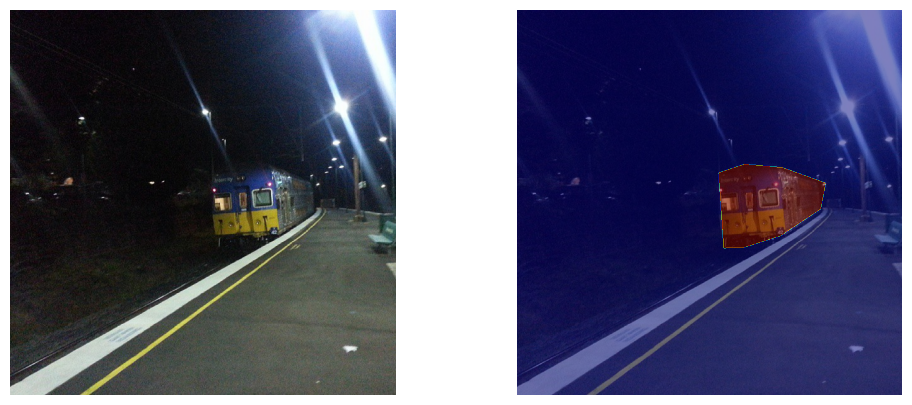

In [23]:
mask = np.zeros_like(segm_map, dtype=np.uint8)
for seg_id in sample["segments"][3]["segment_ids"]:
    mask |= (segm_map == int(seg_id))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(sample_img); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(sample_img); plt.imshow(mask, alpha=0.5, cmap="jet"); plt.axis("off")


In [4]:
# RefCOCO 元数据
ref_p = coco_root / "refcoco" / "refs(unc).p"
with open(ref_p, "rb") as f:
    ref_samples = pickle.load(f, encoding="latin1")
ref_samples[0].keys()


dict_keys(['sent_ids', 'file_name', 'ann_id', 'ref_id', 'image_id', 'split', 'sentences', 'category_id'])

In [5]:
# 利用现成数据构建 Dataset
from flmm.datasets.png import PNGDataset
from transformers import AutoTokenizer
from deepseek_vl.models import VLMImageProcessor  # 按 README 的依赖安装
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-vl-1.3b-chat")
image_processor = VLMImageProcessor.from_pretrained("deepseek-ai/deepseek-vl-1.3b-chat")
ds = PNGDataset(
    json_file=str(png_ann),
    panoptic_json_file=str(panoptic_json),
    panoptic_png_path=str(panoptic_dir),
    tokenizer=tokenizer,
    image_processor=image_processor,
    prompt_template=dict(INSTRUCTION="User: {input}\n\nAssistant:"),
    local_path=str(images_dir)
)
batch = ds[0]
batch.keys(), batch["pixel_values"].shape, batch["padded_masks"].shape



Could not load bitsandbytes native library: libcusparse.so.11: cannot open shared object file: No such file or directory
Traceback (most recent call last):
  File "/home/cvprtemp/miniconda3/envs/flmm/lib/python3.8/site-packages/bitsandbytes/cextension.py", line 109, in <module>
    lib = get_native_library()
  File "/home/cvprtemp/miniconda3/envs/flmm/lib/python3.8/site-packages/bitsandbytes/cextension.py", line 96, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
  File "/home/cvprtemp/miniconda3/envs/flmm/lib/python3.8/ctypes/__init__.py", line 451, in LoadLibrary
    return self._dlltype(name)
  File "/home/cvprtemp/miniconda3/envs/flmm/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: libcusparse.so.11: cannot open shared object file: No such file or directory

CUDA Setup failed despite CUDA being available. Please run the following command to get more information:

python -m bitsandbytes

Inspect the

[2025-10-28 08:26:48,897] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/cvprtemp/miniconda3/envs/flmm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


loading annotations into memory...
Done (t=1.78s)
creating index...
index created!
Image token: >


(dict_keys(['input_ids', 'mask_ids', 'pixel_values', 'padded_masks', 'masks', 'gt_masks', 'image_sizes', 'mask_infos', 'image', 'file_name', 'meta_data', 'labels']),
 torch.Size([3, 384, 384]),
 torch.Size([2, 384, 384]))

In [ ]:
from mmdet.models import DiceLoss, CrossEntropyLoss
from mmseg.models.backbones.unet import InterpConv
from mmdet.datasets import RefCocoDataset